<a href="https://colab.research.google.com/github/Page0526/Pytorch-crash-course/blob/main/deep-neural-networks/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple AutoEncoder and Latent Space Visualization with PyTorch

Ý tưởng của AutoEncoder là encode input dưới latent space xong đó decode ra output (reconstructed image) gần giống với input. Ở đấy input sẽ được encoder như 1 điểm duy nhất (khác với VAE encode input as a distribution)

## Preliminaries

In [ ]:
!pip install torchvision

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# torchsummary for easy checking and debugging
from torchsummary import summary
# torchvision for downloading and processing data
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# Other for notebook UI and latent space visualization
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Checking if CUDA is available on current machine
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Deivce: {DEVICE}')

BATCH_SIZE = 64
EPOCHS = 3
lr = 5e-4

Deivce: cuda


## Loading FashionMNIST Dataset

In [3]:
def collate_fn(batch):
  '''
  Convert datasets from PIL Image to torch tensor, and padding 2 pixels on each side
  '''
  process = transforms.Compose([
      transforms.ToTensor(),
      transforms.Pad([2])
  ])
  # x - images, process each images in the batch
  x = [process(data[0]) for data in batch]
  # torch.concat(tensors, dim=0,*,out=None): concatenates given seq tensors (List of Tensors) in the given dim
  '''
  Eg:
    x = torch.rand(2, 3):
    tensor([[ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497]])
    x = torch.concat((x, x, x), dim=0)
    tensor([[ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497],
          [ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497],
          [ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497]])
    x = torch.concat(x)
    tensor([[ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497],
          [ 0.6580, -1.0969, -0.4614],
          [-0.1034, -0.5790,  0.1497]])
  '''
  x = torch.concat(x).unsqueeze(1)
  # y - labels
  y = torch.LongTensor([data[1] for data in batch])
  return x, y

In [4]:
labels = ["T-shirt/top",
	          "Trouser",
	          "Pullover",
	          "Dress",
	          "Coat",
	          "Sandla",
	          "Shirt",
	          "Sneaker",
	          "Bag",
	          "Ankle boot"]

In [5]:
# download/load datase
train_data = FashionMNIST("./MNIST_DATA",train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA",train=False, download=True)

# put datasets into DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

100%|██████████| 26421880/26421880 [00:12<00:00, 2051402.50it/s]


Extracting ./MNIST_DATA/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATA/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 165130.08it/s]


Extracting ./MNIST_DATA/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATA/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3194415.71it/s]


Extracting ./MNIST_DATA/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATA/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6139402.04it/s]

Extracting ./MNIST_DATA/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATA/FashionMNIST/raw



Batch shape:  torch.Size([64, 1, 32, 32])


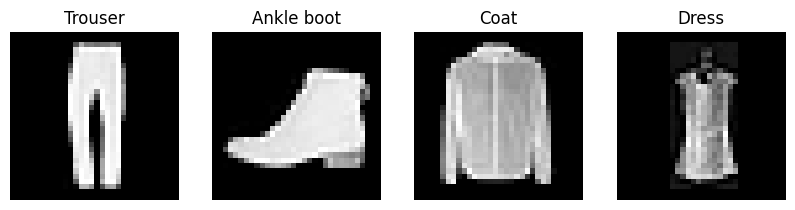

In [6]:
# Visualize data
for _, data in enumerate(train_loader):
  print("Batch shape: ",data[0].shape)
  fig, ax = plt.subplots(1, 4, figsize=(10, 4))

  for i in range(4):
    # Turn 3D tensor to 2D tensor due to image's single channel
    ax[i].imshow(data[0][i].squeeze(), cmap='gray')
    ax[i].axis("off")
    ax[i].set_title(labels[data[1][i]])

  plt.show()
  break

In [7]:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

## AutoEncoder Architecture
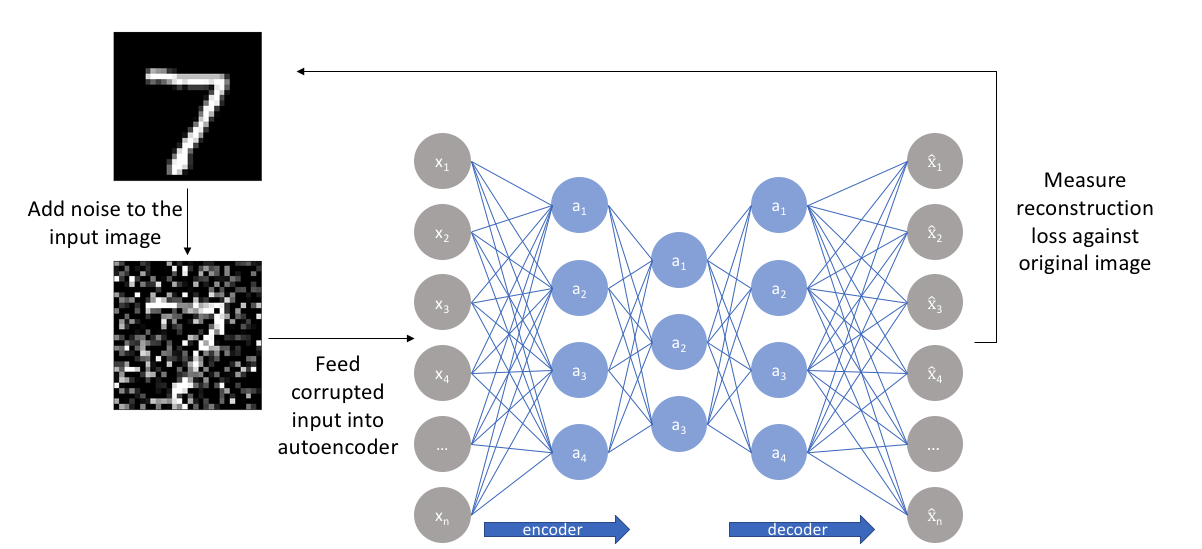

In [ ]:
class Encoder(nn.Module):
  def __init__(self, output_dim=2, use_batchhnorm=False, use_dropout=False):
    super(Encoder, self).__init__()

    # bottleneck dimensionality
    self.output_dim = output_dim

    self.use_dropout = use_dropout
    self.use_batchnorm = use_batchhnorm

    # convolutional layer hyperparameters
    self.layers = LAYERS
    self.kernels = KERNELS
    self.channels = CHANNELS
    self.strides = STRIDES
    self.conv = self.get_convs()

    # layers for latent space projection
    # represent number of neurons in ful
    self.fc_dim = LINEAR_DIM # fully connectied dimension
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(self.fc_dim, self.output_dim)

  def get_convs(self):
    """
    Generating convolutional layers based on model's hyperparams
    """
    conv_layers = nn.Sequential()
    for i in range(self.layers):
      # Input channel for first layer is 1
      if i==0:
        conv_layers.append(nn.Conv2d(1, self.channels[i],
                                     kernel_size=self.kernels[i],
                                     stride=self.strides[i],
                                     padding=1))

      else:
        conv_layers.append(nn.Conv2d())

## AutoEncoder

Here we implement a mirrored encoder-decoder model

### Encoder

### Decoder

### AutoEncoder

## Experiment